In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import os
import time
import math
import shutil

import imageio
import librosa
import librosa.display
from IPython.display import Audio

torch.cuda.is_available()

True

## Data

#### Play an example audio file

In [2]:
general_path = r'GTZAN'
print(list(os.listdir(f'{general_path}/genres_original/')))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [3]:
file_path = r'GTZAN\genres_original\classical\classical.00000.wav'
Audio(file_path)

In [4]:
y, sr = librosa.load(file_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [-0.02008057 -0.01748657  0.00418091 ...  0.01934814  0.027771
  0.03131104] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


#### Trim leading and trailing silence

In [5]:
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [-0.02008057 -0.01748657  0.00418091 ...  0.01934814  0.027771
  0.03131104] 

Audio File shape: (661794,)


#### Get BPM

In [6]:
tempo, _ = librosa.beat.beat_track(y=y, sr = sr)
tempo

95.703125

#### Display waveform

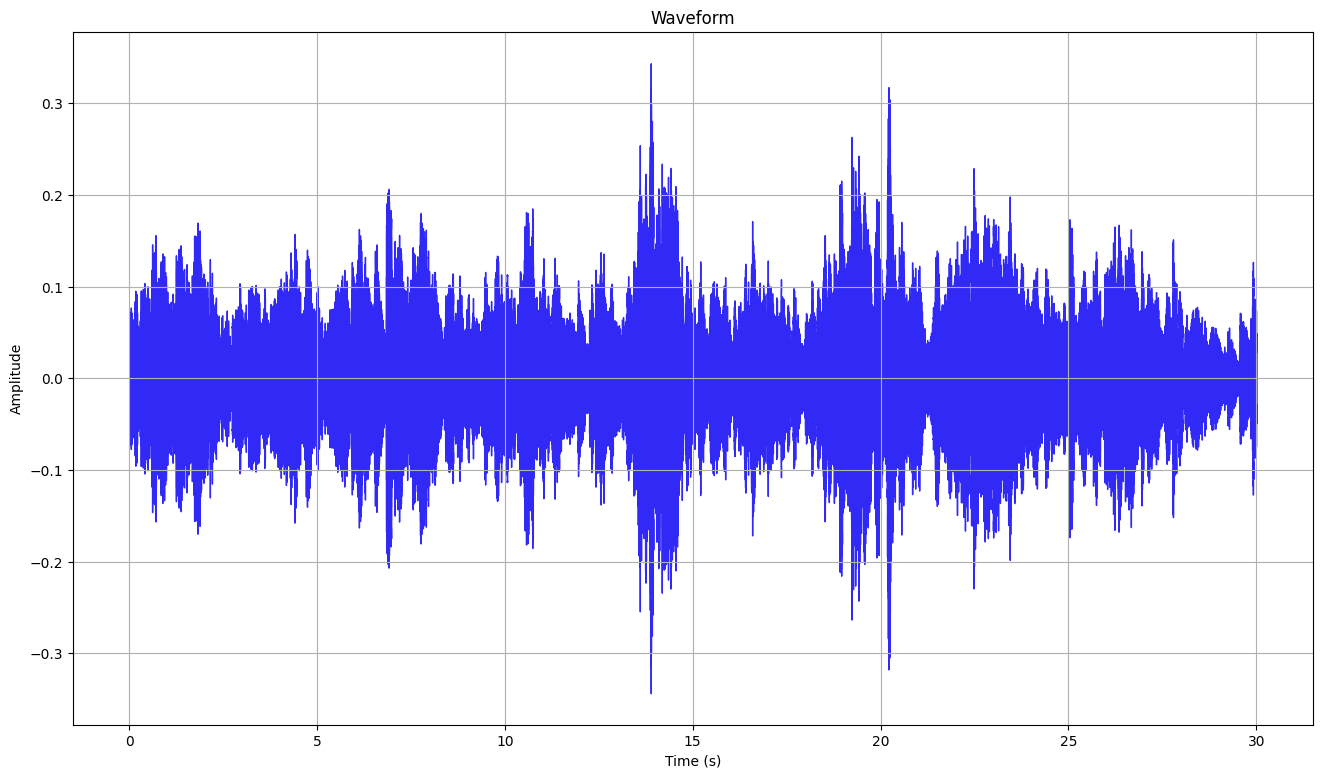

In [7]:
plt.figure(figsize=(16, 9))
librosa.display.waveshow(audio_file, sr=sr, color='#312af7')
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

#### Display STFT

Shape of D object: (1025, 1293)


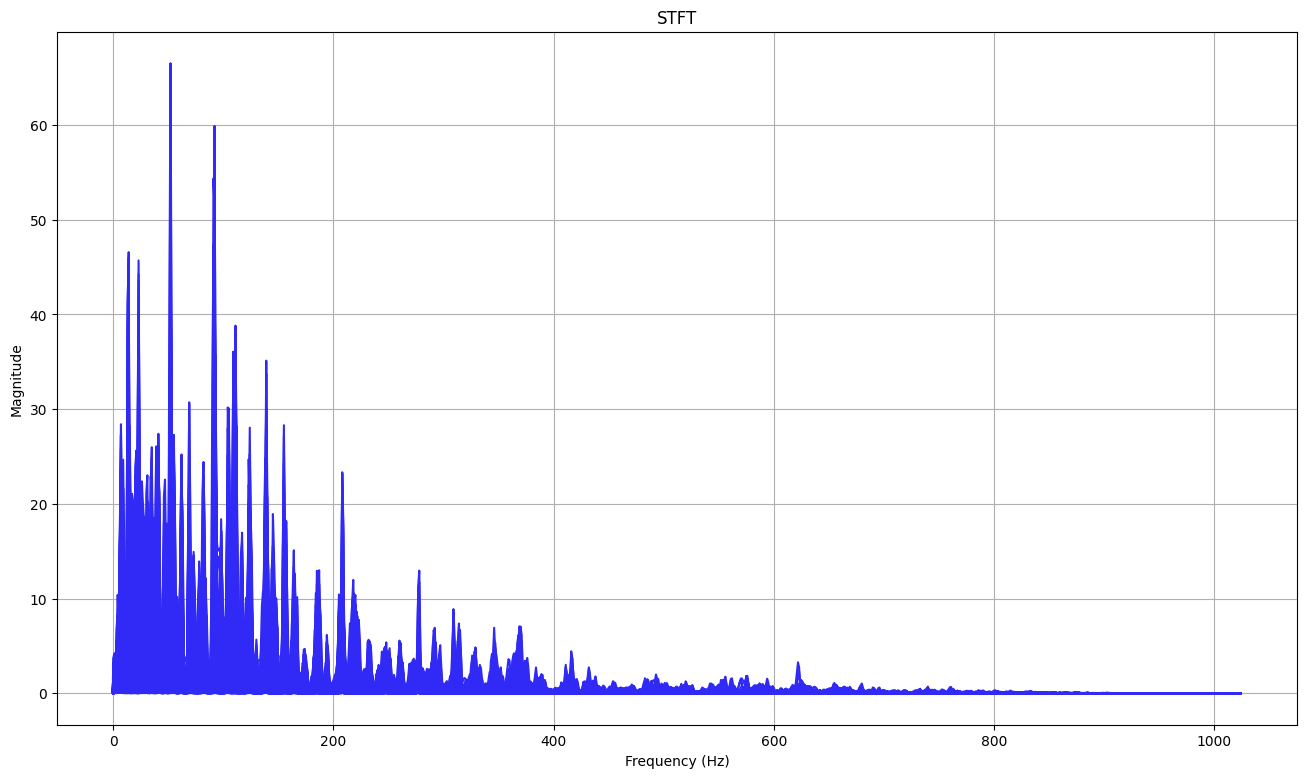

In [8]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

log_scale = False  # Change this to False for linear scale
plt.figure(figsize=(16, 9))
plt.plot(D, color='#312af7')
plt.title('STFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
if log_scale:
    plt.yscale('log')
plt.grid(True)
plt.show()

#### Display spectogram

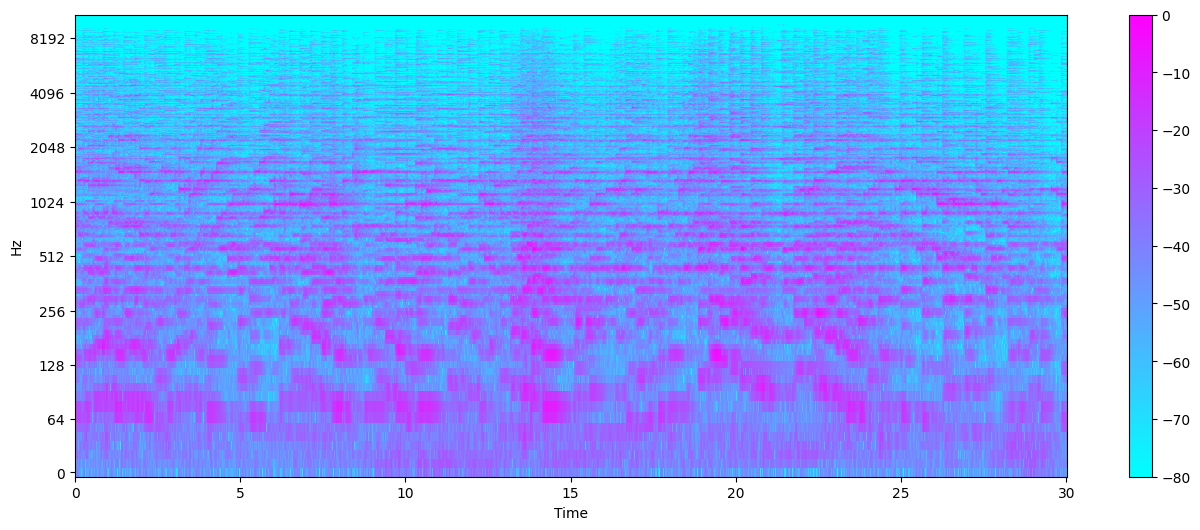

In [9]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

#### Dusplay mel spectogram

In [10]:
file_path = r'GTZAN\genres_original\metal\metal.00036.wav'
Audio(file_path)

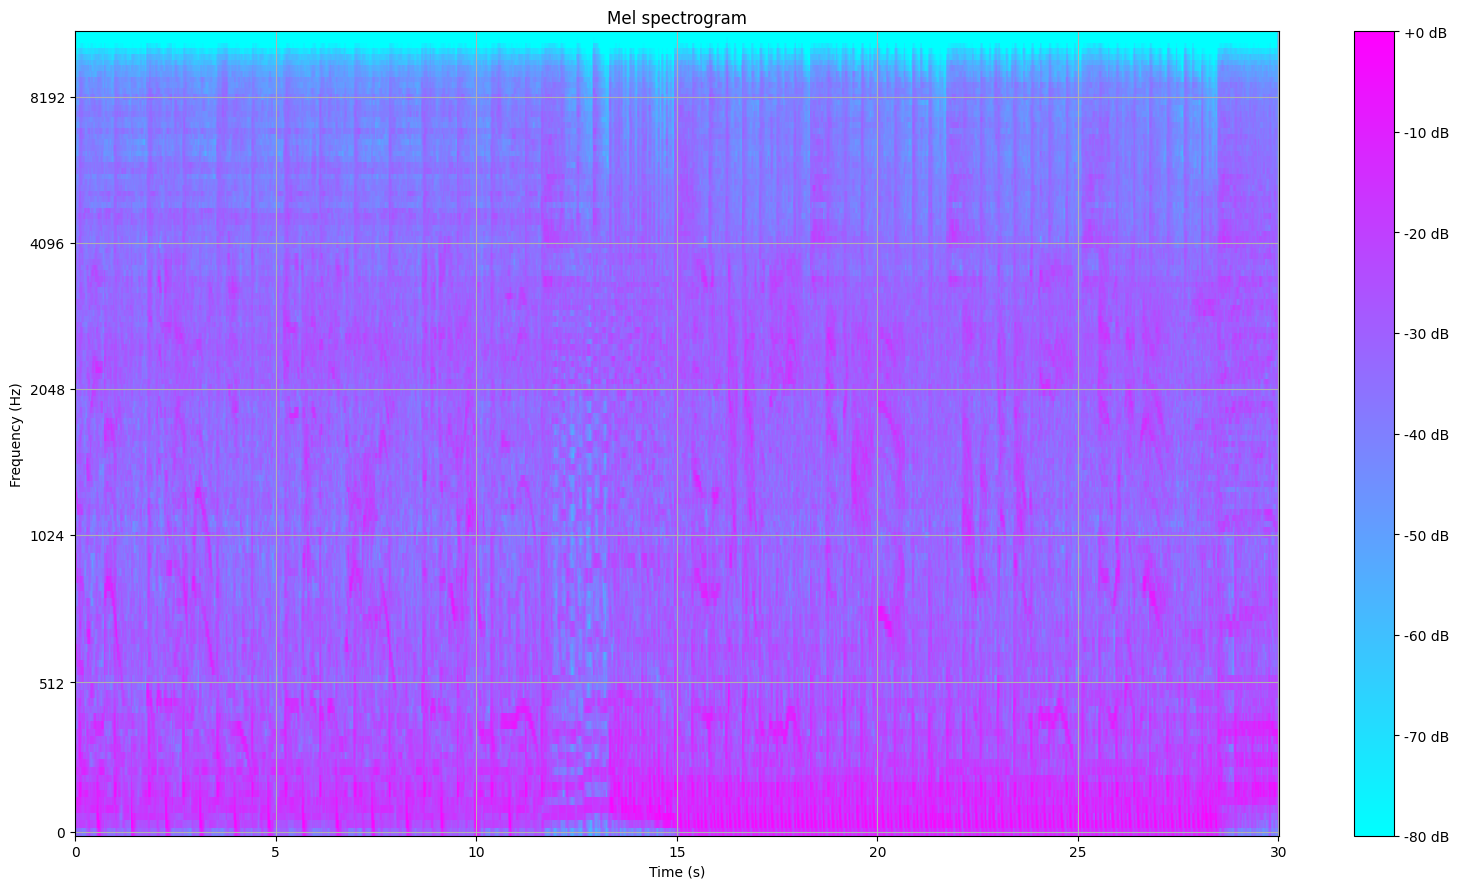

In [11]:
y, sr = librosa.load(file_path)
y, _ = librosa.effects.trim(y)

n_mels=128

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
log_S = librosa.power_to_db(S, ref=np.max)

# Display the Mel spectrogram
plt.figure(figsize=(16, 9))
img = librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='cool')
plt.title('Mel spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(img, format='%+02.0f dB')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Display audio as mel spectogram

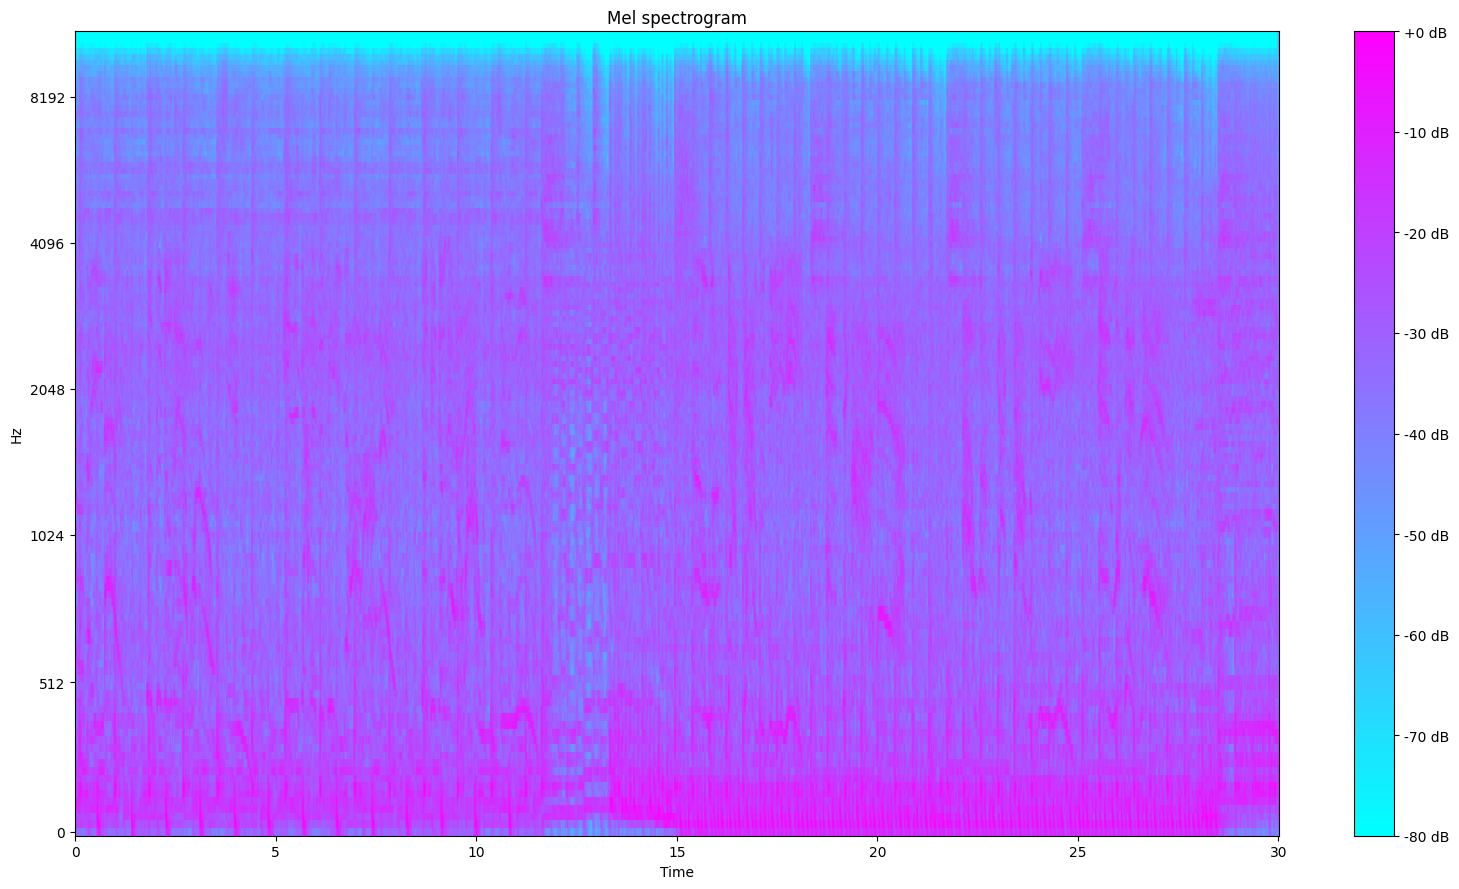

In [12]:
# Convert audio to a Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

# Display the Mel spectrogram
plt.figure(figsize=(16, 9))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='cool')
plt.title('Mel spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

# EDA

In [13]:
data = pd.read_csv(r'GTZAN\features_30_sec.csv')
data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

#### Correlation heat map for feature means

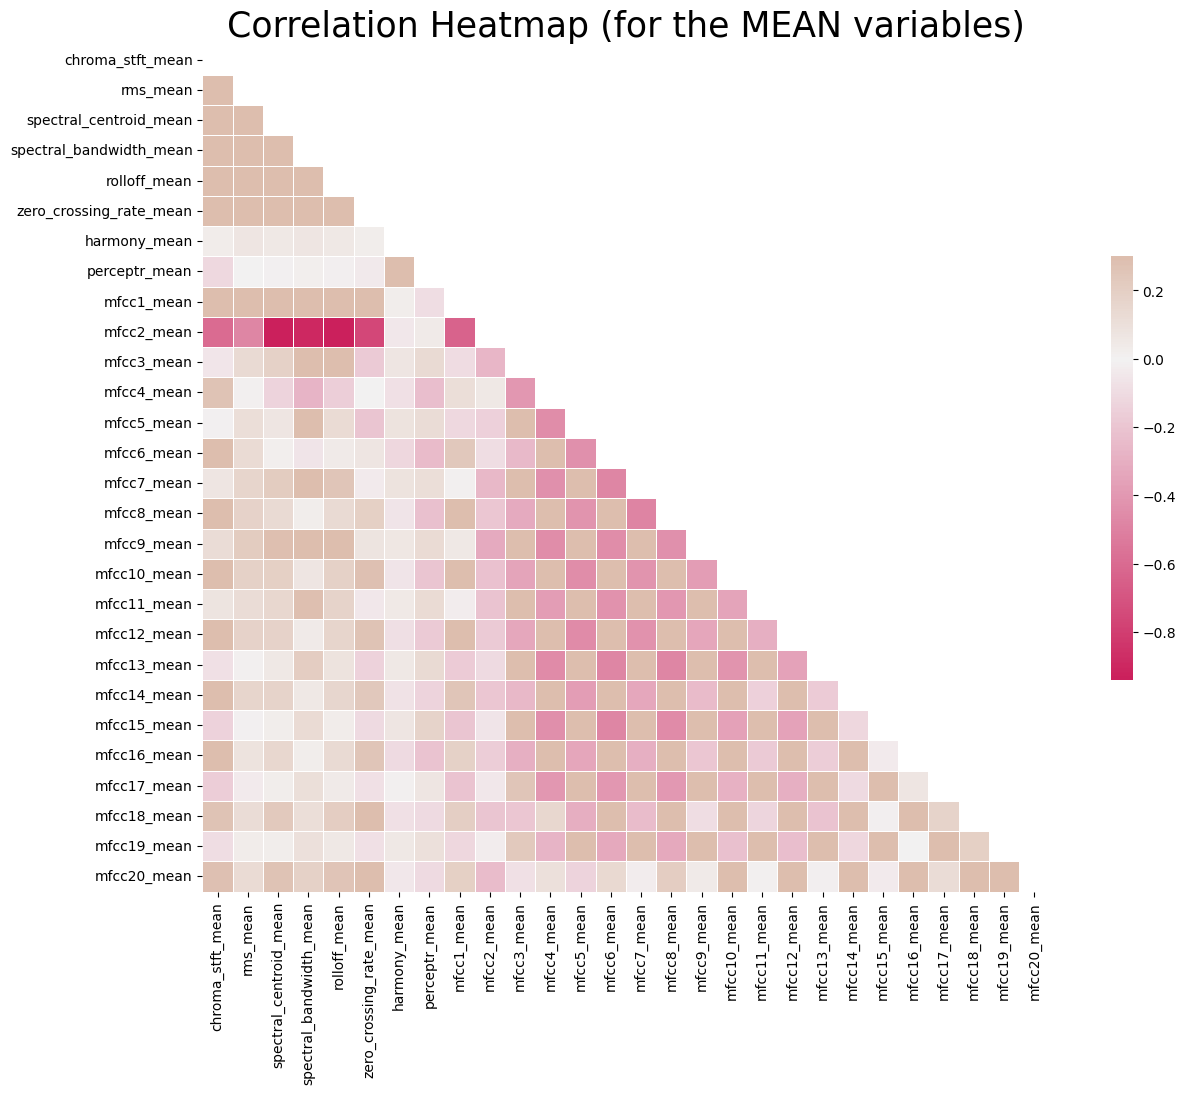

In [14]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

#### Box plot for genres distributions

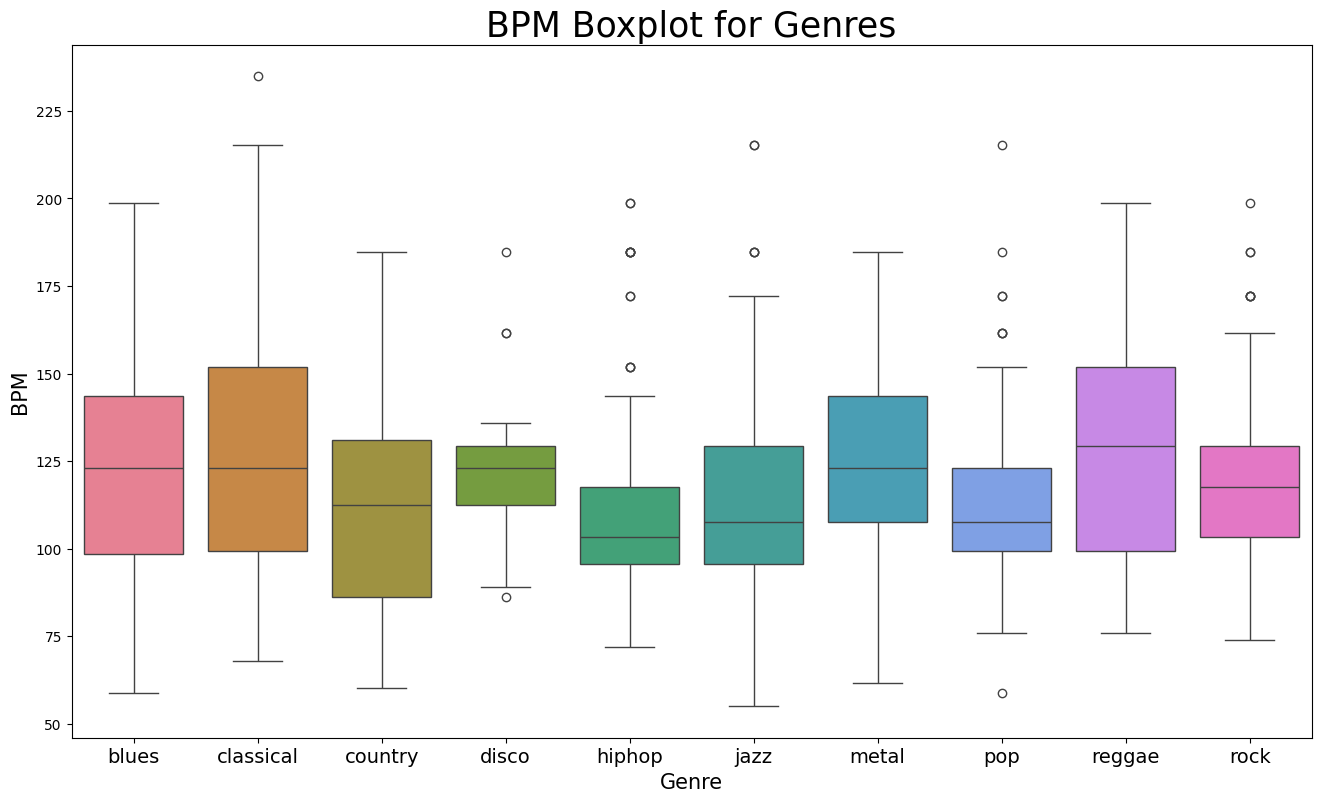

In [15]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x="label", y="tempo", hue="label", data=x, palette='husl', legend=False);

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10);
plt.xlabel("Genre", fontsize=15)
plt.ylabel("BPM", fontsize=15)
plt.savefig("BPM Boxplot.jpg")

#### Principal Component Analysis

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

# 44.93 variance explained

array([0.2439355 , 0.21781804])

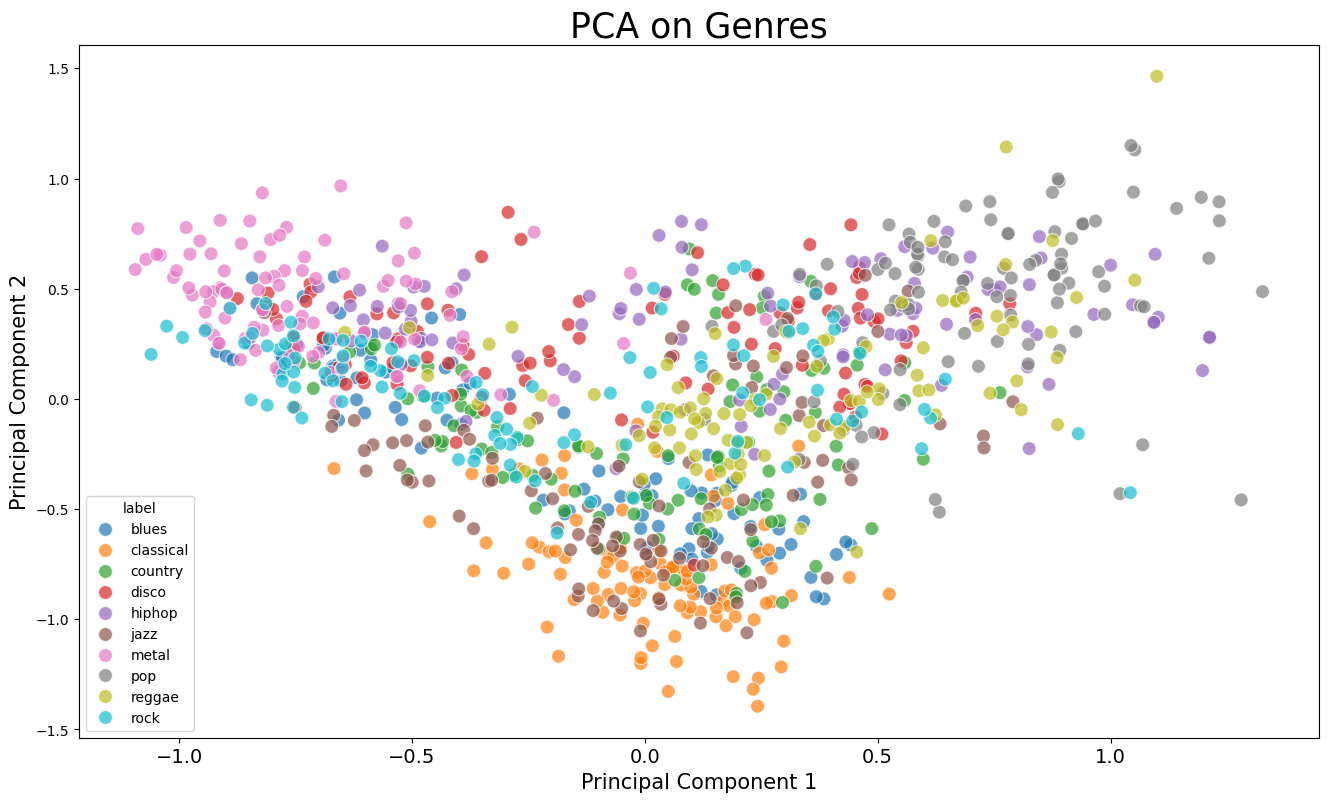

In [17]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scatter.jpg")

# ML Classification

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [19]:
data = pd.read_csv(r'GTZAN\features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  
0   43.771767  blues  
1   59.943081  blues  
2   33.105122  blues  
3   32.023678  blues  
4   29.146694  blues  

[5 rows x 59 columns]

#### Setting feature and target variables

In [20]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

# Normalize so everything is on the same scale. 
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns=cols)

#### Encode labels from strings to ints

In [21]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

#### Data split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Function to assess model accuracy

In [23]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5))

#### Model comparison

In [24]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

[[100   6  61  12   1  19  85   0  12  23]
 [  0 275   1   0   0  21   0   0   1  10]
 [ 20  11 166  25   4   8  22  11  10   9]
 [ 13   4  30 102  13   2  57  46  17  17]
 [  8   1  15  36 109   0  44  60  36   2]
 [ 10  59  34   6   0 117   8  13   5  34]
 [  5   0   3  11   3   0 269   0   3   9]
 [  0   0  17  18   2   1   0 208  13   8]
 [ 19   1  61  10  23   3   6  29 149  15]
 [  8   6  49  40   2   7  96  13  17  62]]
Accuracy Naive Bayes : 0.51952


In [25]:
# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

[[257   9   9   3   8  15  12   0   6   0]
 [  1 302   3   0   0   2   0   0   0   0]
 [ 51   7 150  12   7  29   0  13  13   4]
 [ 15  10  19 145  62   7   2  25  14   2]
 [ 15   5   8   2 237   0   6  15  21   2]
 [ 17  48   6   1   2 203   0   2   7   0]
 [ 32   1   5  13  12   0 231   0   5   4]
 [  1   2   7   4  19   4   0 221   7   2]
 [ 21   2  15   8  61   7   3   4 192   3]
 [ 76  13  30  46  25  29  11  14  30  26]]
Accuracy Stochastic Gradient Descent : 0.65532


In [26]:
# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

[[256   5  22   4   2   8   6   0  10   6]
 [  0 297   1   0   0  10   0   0   0   0]
 [  9   2 230  11   1  13   0   1  12   7]
 [  7   6   8 246   8   0   2   4   6  14]
 [  7   1  15  24 217   0   9  21  14   3]
 [  2  30  16   2   0 233   0   2   1   0]
 [  6   0   2  15   5   0 252   0   4  19]
 [  0   0   6  17   2   2   0 229  10   1]
 [  3   1  16  20  13   0   2  11 248   2]
 [ 11   1  20  35   0   7   7   2  10 207]]
Accuracy KNN : 0.80581


In [27]:
# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decision trees")

[[166   0  35  22   8  17  15   7  17  32]
 [  4 253  11   1   0  24   1   4   2   8]
 [ 25   7 147   8   9  27  11   6  13  33]
 [ 13   3  15 170  22   6   9  15  18  30]
 [  7   1  11  27 210   3  13  15  19   5]
 [ 14  15  14   5   0 207   4  12   1  14]
 [ 12   0   4  12   7   3 243   2   6  14]
 [  2   1  11  12  15   5   1 199  10  11]
 [ 13   3  18  22  24   4   3  13 201  15]
 [ 18   4  33  25  11  19  26   8  15 141]]
Accuracy Decision trees : 0.64631


In [28]:
# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

[[246   1  31   8   4   8  15   0   6   0]
 [  0 294   1   0   0  12   0   0   0   1]
 [ 13   1 212  12   0  23   3   3   9  10]
 [  1   4  11 235  14   1   5   8  10  12]
 [  4   0   7   8 250   2  13  15  10   2]
 [  7  21   5   1   0 251   0   0   1   0]
 [  1   0   1   2   3   1 281   0   6   8]
 [  0   0  12   4   2   1   0 238   5   5]
 [  5   2   9  11   7   4   4  17 254   3]
 [  7   2  29  34   1  12  19   4  13 179]]
Accuracy Random Forest : 0.81415


In [29]:
# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

[[241   5  10   9   2  12  24   0   7   9]
 [  0 294   2   0   0  10   0   0   0   2]
 [ 19   0 192  18   0  23   1   5   5  23]
 [  2   6   7 199  18   7  10  12  14  26]
 [  7   2   7  18 220   0   8  16  28   5]
 [ 12  25   9   2   0 234   0   1   2   1]
 [ 10   0   0   7   4   0 270   0   2  10]
 [  0   1  10   8   4   1   0 233   4   6]
 [ 13   2  16  18  20   3   5  10 220   9]
 [ 19   2  24  45   7  11  16   9  10 157]]
Accuracy Support Vector Machine : 0.75409


In [30]:
# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

[[212   5  12   7   4  18  40   0  11  10]
 [  2 287   5   0   0  10   0   0   0   4]
 [ 23   1 166  18   2  21   1  19   9  26]
 [  3   5  15 182  23   3  16  21  15  18]
 [  8   2   8  17 201   0  15  24  31   5]
 [ 11  28  14   5   1 214   0   2   7   4]
 [ 10   0   0   7   4   0 266   0   3  13]
 [  0   0  14   8  11   0   0 226   3   5]
 [ 14   1  19  12  29   5   8  10 210   8]
 [ 35   3  25  32   5  14  22  18  19 127]]
Accuracy Logistic Regression : 0.6977


c:\Users\dmiln\anaconda3\envs\pyto23\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

[[187   2  53   3   5  17  21   0  14  17]
 [  5 286   3   1   0  11   0   0   1   1]
 [ 22   2 154   9   1  27   0   6  20  45]
 [  2   4  10 163  30   4   9  18  18  43]
 [  5   0   4  20 210   3  10  17  35   7]
 [ 11  27  20   0   0 208   1   2   3  14]
 [ 16   0   1   7   6   0 259   0   0  14]
 [  0   0   2   8   5   0   0 235  13   4]
 [  5   1  24  19  31   1   2  13 216   4]
 [ 23   3  49  41   2  15  18  10  16 123]]
Accuracy Neural Nets : 0.68101


c:\Users\dmiln\anaconda3\envs\pyto23\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [32]:
# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

[[277   1  14   9   1   5   4   0   4   4]
 [  0 299   0   0   0   7   0   0   0   2]
 [ 11   1 248   4   0  12   0   4   5   1]
 [  2   3   7 266   1   1   1  13   0   7]
 [  3   1   4   6 281   3   3   5   5   0]
 [  1  11   7   0   0 264   0   1   0   2]
 [  3   0   3   1   6   0 283   0   3   4]
 [  0   0   3   1   1   0   0 256   4   2]
 [  0   2   9   4   7   2   2   4 282   4]
 [  4   1  13  17   3   4   9   1   3 245]]
Accuracy Cross Gradient Booster : 0.90123


In [33]:
# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

[[216   0  44   4   9  13  20   0  11   2]
 [  0 278   3   0   0  23   0   0   1   3]
 [ 17   1 209   4   3  32   1   6   8   5]
 [  4   3  13 200  33   7   4  20   5  12]
 [  4   1  10  22 236   3   6  18   8   3]
 [  7  22  15   0   1 239   0   0   1   1]
 [  1   0   2   3   8   5 272   0   6   6]
 [  0   0  16   5   7   2   0 232   3   2]
 [  7   3  44  11  13   5   2  13 214   4]
 [  8   4  49  27   4  16  24   9  15 144]]
Accuracy Cross Gradient Booster (Random Forest) : 0.74741


#### Using XGBoost

Accuracy : 0.90123 



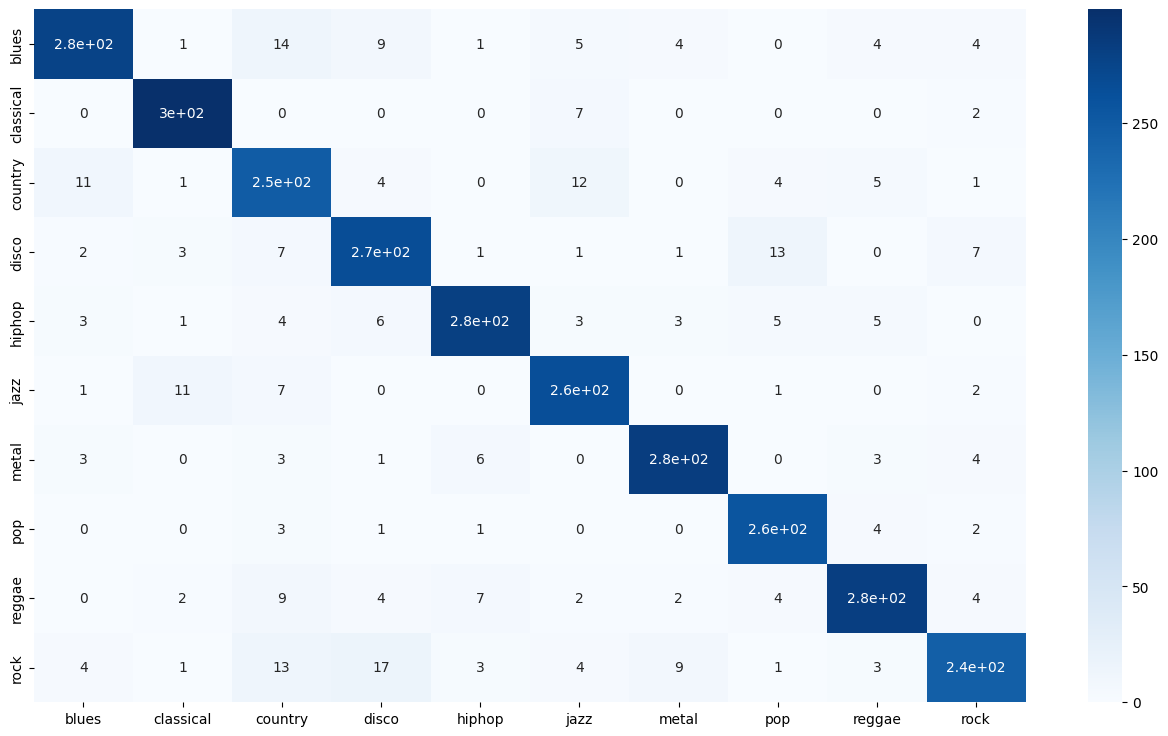

In [34]:
# Final model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

#### Feature importance

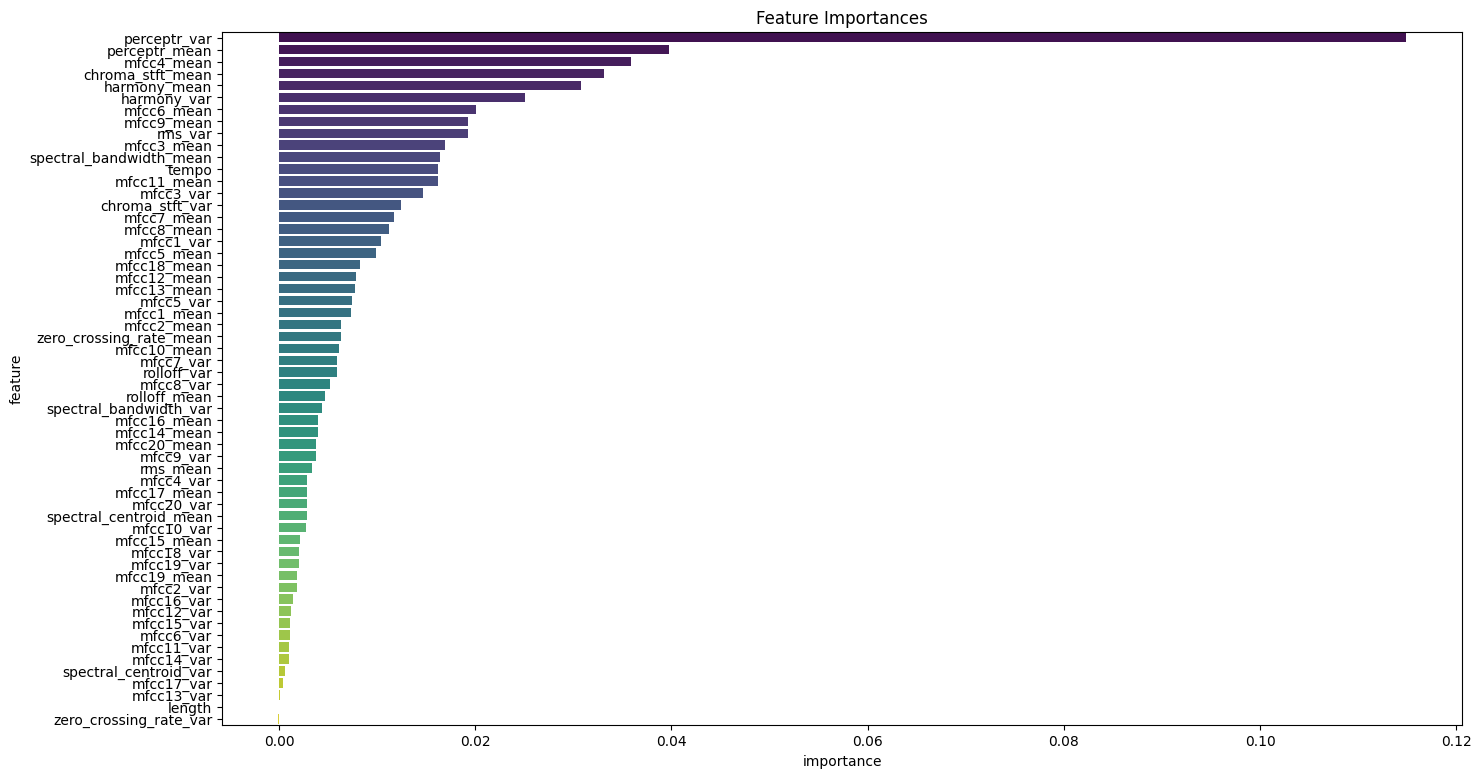

In [35]:
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import seaborn as sns

perm = PermutationImportance(estimator=xgb, random_state=1)
perm.fit(X_test, y_test)

# Get feature importances
importances = perm.feature_importances_

# Create a DataFrame for easier plotting
df = pd.DataFrame({'feature': X_test.columns, 'importance': importances})

# Sort by importance
df = df.sort_values(by='importance', ascending=False)

# Plot using Seaborn
plt.figure(figsize=(16, 9))
sns.barplot(x='importance', y='feature', data=df, palette='viridis')
plt.title('Feature Importances')
plt.show()